In [1]:
# Import necessary modules
import numpy as np
import os
import pandas as pd
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../'))
sys.path.insert(0, project_root)

from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_helpers import get_sim_inputs_from_hourly, gaussian_kernel, get_mu_from_sigma, logistic_step
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting import *

## Model Parameters

In [2]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 1.0,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = True,
    verbose          = False
)

In [3]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [4]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.01   # 1/hr 0.005
)

In [5]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [6]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

In [7]:
# Set typical disturbances
typical_disturbances = ModelTypicalDisturbances()

## Input Disturbances

In [8]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [9]:
# Set ModelDisturbances
disturbances = ModelDisturbances(
    precipitation = 0.5 * hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(), # let's say it's a drought year
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Plot inputs and disturbances

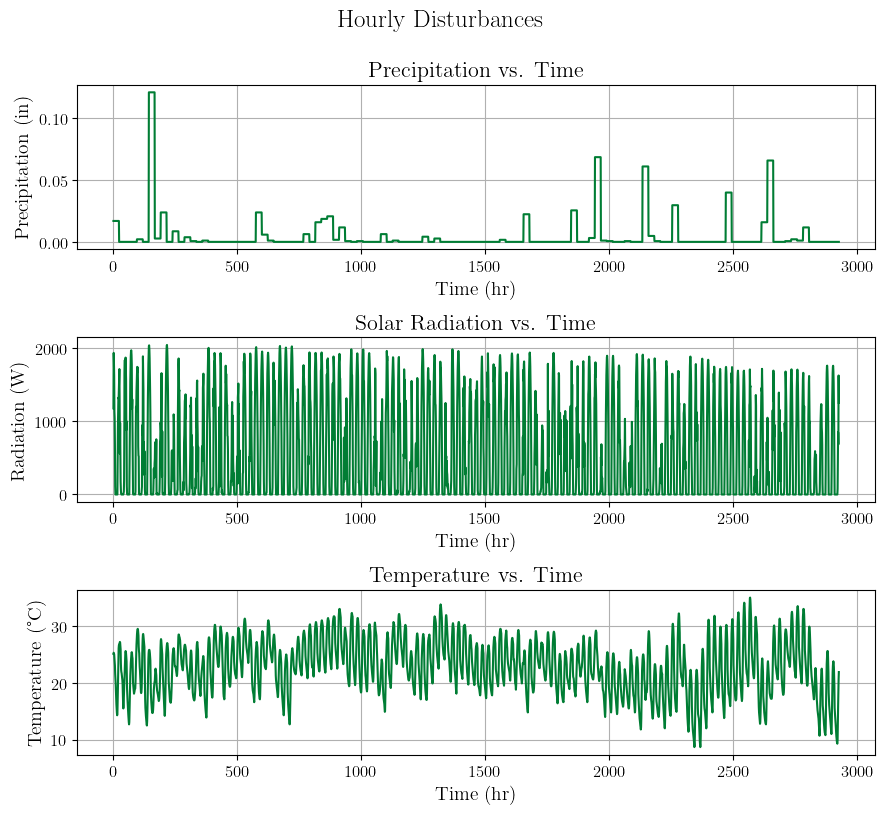

In [10]:
plot_hourly_inputs(
    disturbances
)

## Simulation of Plant Growth over Season

In [11]:
# Unpack model parameters
dt = model_params.dt
total_time_steps = model_params.total_time_steps
simulation_hours = model_params.simulation_hours
closed_form      = True

# Unpack disturbances
hourly_precipitation = disturbances.precipitation
hourly_temperature   = disturbances.temperature
hourly_radiation     = disturbances.radiation

# Unpack initial conditions
h0 = initial_conditions.h0
A0 = initial_conditions.A0
N0 = initial_conditions.N0
c0 = initial_conditions.c0
P0 = initial_conditions.P0

# Unpack growth rates
ah = growth_rates.ah
aA = growth_rates.aA
aN = growth_rates.aN
ac = growth_rates.ac
aP = growth_rates.aP

# Unpack carrying capacities
kh = carrying_capacities.kh
kA = carrying_capacities.kA
kN = carrying_capacities.kN
kc = carrying_capacities.kc
kP = carrying_capacities.kP

# Unpack sensitivities
sigma_W = sensitivities.sigma_W
sigma_F = sensitivities.sigma_F
sigma_T = sensitivities.sigma_T
sigma_R = sensitivities.sigma_R

# Unpack typical disturbances
W_typ = typical_disturbances.typical_water
T_typ = typical_disturbances.typical_temperature
R_typ = typical_disturbances.typical_radiation

# Unpack input disturbances
precipitation = get_sim_inputs_from_hourly(
    hourly_array     = hourly_precipitation,
    dt               = dt,
    simulation_hours = simulation_hours,
    mode             = 'split')
temperature = get_sim_inputs_from_hourly(
    hourly_array     = hourly_temperature,
    dt               = dt,
    simulation_hours = simulation_hours,
    mode             = 'split')
radiation = get_sim_inputs_from_hourly(
    hourly_array     = hourly_radiation,
    dt               = dt,
    simulation_hours = simulation_hours,
    mode             = 'split')

# Initialize storage for state variables
h = np.full(total_time_steps, h0)
A = np.full(total_time_steps, A0)
N = np.full(total_time_steps, N0)
c = np.full(total_time_steps, c0)
P = np.full(total_time_steps, P0)

# Pre-calculate the mu values that correspond to 95% absorption for each sigma ("sensitivity")
mu_W = get_mu_from_sigma(sigma_W/dt)
mu_T = get_mu_from_sigma(sigma_T/dt)
mu_R = get_mu_from_sigma(sigma_R/dt)

# Convolve input disturbances with Gaussian kernels to model delayed absorption/metalysis
kernel_W = gaussian_kernel(mu_W, sigma_W/dt, total_time_steps)
kernel_T = gaussian_kernel(mu_T, sigma_T/dt, total_time_steps)
kernel_R = gaussian_kernel(mu_R, sigma_R/dt, total_time_steps)

delayed_water       = np.convolve(precipitation, kernel_W, mode="full")[:total_time_steps]
delayed_temperature = np.convolve(temperature,   kernel_T, mode="full")[:total_time_steps]
delayed_radiation   = np.convolve(radiation,     kernel_R, mode="full")[:total_time_steps]

# Calculate the cumulative values over time from the delayed values
cumulative_water       = np.cumsum(delayed_water)
cumulative_temperature = np.cumsum(delayed_temperature)
cumulative_radiation   = np.cumsum(delayed_radiation)

# Calculate the differences between the expected and actual cumulative values
cumulative_average_water       = np.abs((W_typ * np.arange(total_time_steps) - cumulative_water)       / (W_typ * np.arange(1, total_time_steps + 1)))
cumulative_average_temperature = np.abs((T_typ * np.arange(total_time_steps) - cumulative_temperature) / (T_typ * np.arange(1, total_time_steps + 1)))
cumulative_average_radiation   = np.abs((R_typ * np.arange(total_time_steps) - cumulative_radiation)   / (R_typ * np.arange(1, total_time_steps + 1)))

# Calculate the cumulative deltas over time
cumulative_divergence_water       = np.cumsum(cumulative_average_water)       / np.arange(1, total_time_steps + 1)
cumulative_divergence_temperature = np.cumsum(cumulative_average_temperature) / np.arange(1, total_time_steps + 1)
cumulative_divergence_radiation   = np.cumsum(cumulative_average_radiation)   / np.arange(1, total_time_steps + 1)

# Then use the cumulative deltas to calculate the nutrient factors for each time step
nuW = np.exp(-sensitivities.alpha * cumulative_divergence_water)
nuF = 0.1
nuT = np.exp(-sensitivities.alpha * cumulative_divergence_temperature)
nuR = np.exp(-sensitivities.alpha * cumulative_divergence_radiation)

# Calculate the instantaneous adjusted growth rates and carrying capacities
ah_hat = np.clip(ah * (nuF * nuT * nuR)**(1/3), 0, 2 * ah)
aA_hat = np.clip(aA * (nuF * nuT * nuR)**(1/3), 0, 2 * aA)
aN_hat = np.clip(aN, 0, 2 * aN) * np.ones(total_time_steps)
ac_hat = np.clip(ac * ( (1/nuT) * (1/nuR) )**(1/2), 0, 2 * ac)
aP_hat = np.clip(aP * (nuT * nuR)**(1/2), 0, 2 * aP)

kh_hat = np.clip(kh * (nuF * nuT * nuR)**(1/3), 0, 2 * kh)
kA_hat = np.clip(kA * (nuW * nuF * nuT * nuR * (kh_hat/kh))**(1/5), 0, 2 * kA)
kN_hat = np.clip(kN * (nuT * nuR)**(1/2), 0, 2 * kN) * np.ones(total_time_steps)
kc_hat = np.clip(kc * (nuW * (1/nuT) * (1/nuR))**(1/3), 0, 2 * kc)
kP_hat = np.clip(kP * (nuW * nuF * nuT * nuR * (kh_hat/kh) * (kA_hat/kA) * (kc_hat/kc))**(1/7), 0, 2 * kP)

# Run the season simulation for the given member
for t in range(total_time_steps - 1):

    # Logistic-style updates
    if closed_form:
        h[t+1] = logistic_step(h[t], ah_hat[t], kh_hat[t], dt)
        A[t+1] = logistic_step(A[t], aA_hat[t], kA_hat[t], dt)
        N[t+1] = logistic_step(N[t], aN_hat[t], kN_hat[t], dt)
        c[t+1] = logistic_step(c[t], ac_hat[t], kc_hat[t], dt)
        P[t+1] = logistic_step(P[t], aP_hat[t], kP_hat[t], dt)

    else:
        # Forward Euler integration
        h[t+1] = h[t] + dt * (ah_hat[t] * h[t] * (1 - h[t]/max(kh_hat[t], 1e-9)))
        A[t+1] = A[t] + dt * (aA_hat[t] * A[t] * (1 - A[t]/max(kA_hat[t], 1e-9)))
        N[t+1] = N[t] + dt * (aN_hat[t] * N[t] * (1 - N[t]/max(kN_hat[t], 1e-9)))
        c[t+1] = c[t] + dt * (ac_hat[t] * c[t] * (1 - c[t]/max(kc_hat[t], 1e-9)))
        P[t+1] = P[t] + dt * (aP_hat[t] * P[t] * (1 - P[t]/max(kP_hat[t], 1e-9)))

        # Enforce non-negativity explicitly
        h[t+1] = max(h[t+1], 0.0)
        A[t+1] = max(A[t+1], 0.0)
        N[t+1] = max(N[t+1], 0.0)
        c[t+1] = max(c[t+1], 0.0)
        P[t+1] = max(P[t+1], 0.0)

    # Pure profit
    ga_params = GeneticAlgorithmParams()
    profit = ga_params.weight_fruit_biomass * P[-1]
    expenses = 0.0
    revenue = profit - expenses

print(f"Final plant height: {h[-1]:.4f} m")
print(f"Final leaf area: {A[-1]:.4f} m2")
print(f"Final number of leaves: {N[-1]:.4f}")
print(f"Final number of spikelets: {c[-1]:.4f}")
print(f"Final fruit biomass: {P[-1]:.4f} kg")
print(f"Profit: ${profit:.2f}")

# Save all the data of interest to a csv for further analysis if verbose is True
df = pd.DataFrame({
    'h': h.flatten(),
    'A': A.flatten(),
    'N': N.flatten(),
    'c': c.flatten(),
    'P': P.flatten(),
    'delayed_water':       delayed_water.flatten(),
    'delayed_temperature': delayed_temperature.flatten(),
    'delayed_radiation':   delayed_radiation.flatten(),
    'cumulative_water':       cumulative_water.flatten(),
    'cumulative_temperature': cumulative_temperature.flatten(),
    'cumulative_radiation':   cumulative_radiation.flatten(),
    'cumulative_divergence_water':       cumulative_divergence_water.flatten(),
    'cumulative_divergence_temperature': cumulative_divergence_temperature.flatten(),
    'cumulative_divergence_radiation':   cumulative_divergence_radiation.flatten(),
    'nuW': nuW.flatten(),
    'nuT': nuT.flatten(),
    'nuR': nuR.flatten(),
    'ah_hat': ah_hat.flatten(),
    'aA_hat': aA_hat.flatten(),
    'aN_hat': aN_hat.flatten(),
    'ac_hat': ac_hat.flatten(),
    'aP_hat': aP_hat.flatten(),
    'kh_hat': kh_hat.flatten(),
    'kA_hat': kA_hat.flatten(),
    'kN_hat': kN_hat.flatten(),
    'kc_hat': kc_hat.flatten(),
    'kP_hat': kP_hat.flatten(),
})

df.to_csv("output_get_cost.csv", index=False)

Final plant height: 0.9965 m
Final leaf area: 0.2126 m2
Final number of leaves: 15.2565
Final number of spikelets: 769.6152
Final fruit biomass: 0.1001 kg
Profit: $445.36


In [12]:
# Read results from the output csv file
output = pd.read_csv('output_get_cost.csv')

h = output['h'].to_numpy()
A = output['A'].to_numpy()
N = output['N'].to_numpy()
c = output['c'].to_numpy()
P = output['P'].to_numpy()

delayed_water       = output['delayed_water'].to_numpy()
delayed_temperature = output['delayed_temperature'].to_numpy()
delayed_radiation   = output['delayed_radiation'].to_numpy()

cumulative_water       = output['cumulative_water'].to_numpy()
cumulative_temperature = output['cumulative_temperature'].to_numpy()
cumulative_radiation   = output['cumulative_radiation'].to_numpy()

delta_cumulative_water       = output['cumulative_divergence_water'].to_numpy()
delta_cumulative_temperature = output['cumulative_divergence_temperature'].to_numpy()
delta_cumulative_radiation   = output['cumulative_divergence_radiation'].to_numpy()

nuWs = output['nuW'].to_numpy()
nuTs = output['nuT'].to_numpy()
nuRs = output['nuR'].to_numpy()

ah_hat = output['ah_hat'].to_numpy()
aA_hat = output['aA_hat'].to_numpy()
aN_hat = output['aN_hat'].to_numpy()
ac_hat = output['ac_hat'].to_numpy()
aP_hat = output['aP_hat'].to_numpy()

kh_hat = output['kh_hat'].to_numpy()
kA_hat = output['kA_hat'].to_numpy()
kN_hat = output['kN_hat'].to_numpy()
kc_hat = output['kc_hat'].to_numpy()
kP_hat = output['kP_hat'].to_numpy()

## Plot crop growth results

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:247: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:255: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:263: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

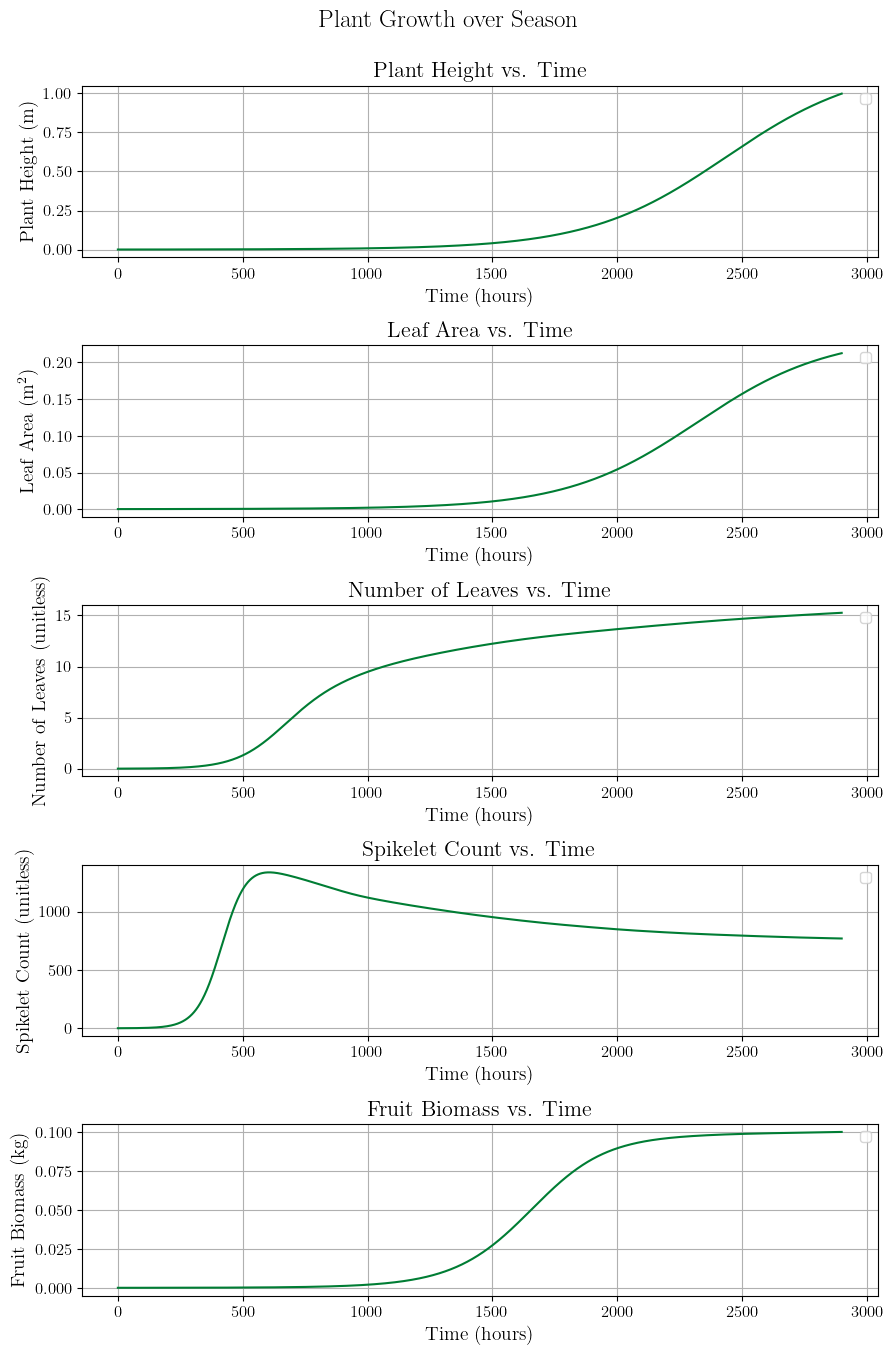

In [13]:
plot_crop_growth_results(
    hs = [h],
    As = [A],
    Ns = [N],
    cs = [c],
    Ps = [P]
)

## Plot cumulative value evolution

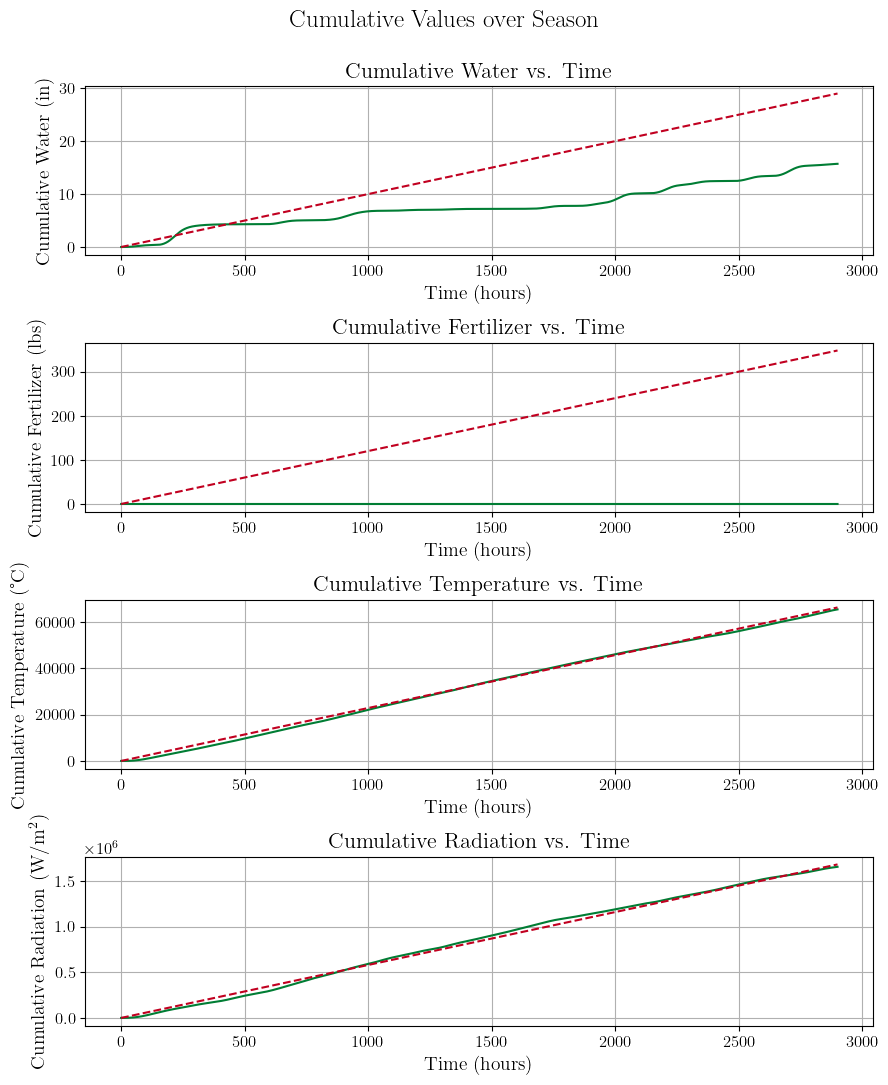

In [14]:
plot_cumulative_values(
    cumulative_water,
    np.zeros_like(cumulative_water),
    cumulative_temperature,
    cumulative_radiation,
    typical_disturbances
)

## Plot the deltas between actual and expected cumulative value

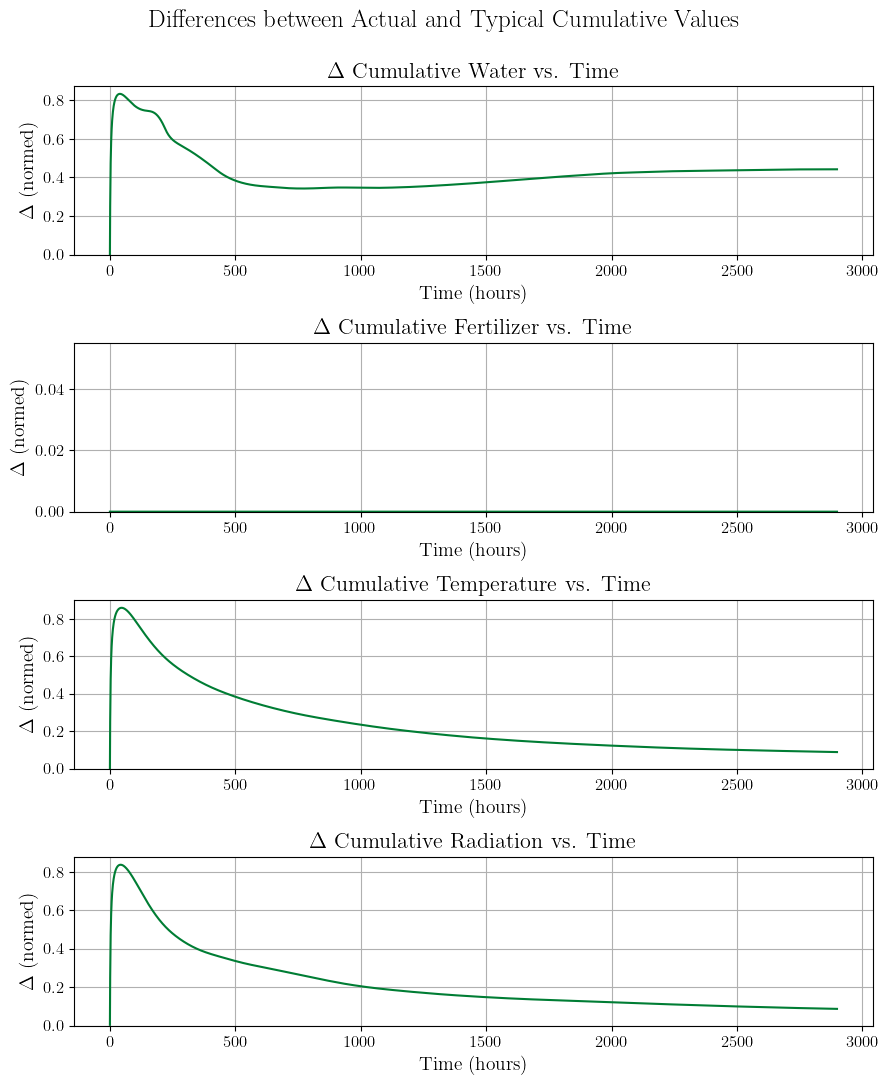

In [15]:
plot_actual_vs_expected_cumulatives(
    delta_cumulative_water,
    np.zeros_like(delta_cumulative_water),
    delta_cumulative_temperature,
    delta_cumulative_radiation
)

## Plot nutrient factor evolution

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:576: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:586: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:596: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

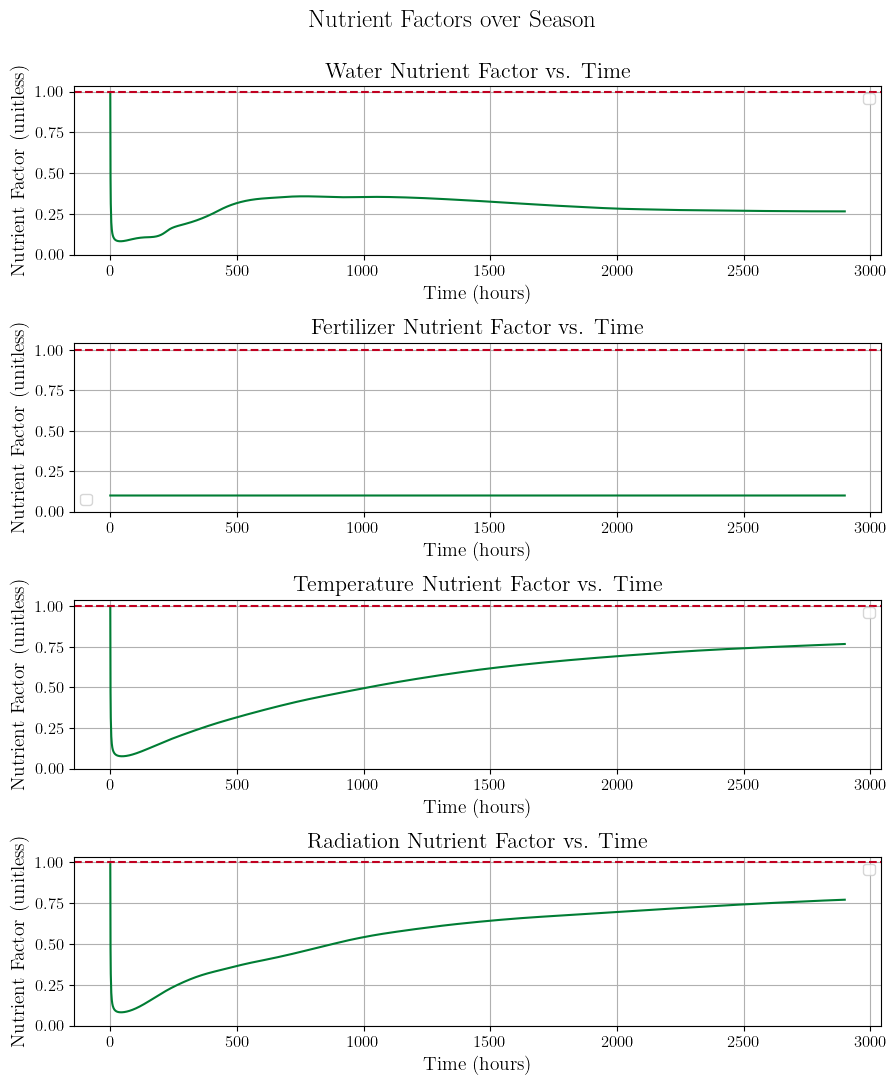

In [16]:
plot_nutrient_factor_evolution(
    [nuWs],
    [np.ones_like(nuWs)*0.1],
    [nuTs],
    [nuRs]
)

## Plot growth rates over time

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:668: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:678: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:688: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

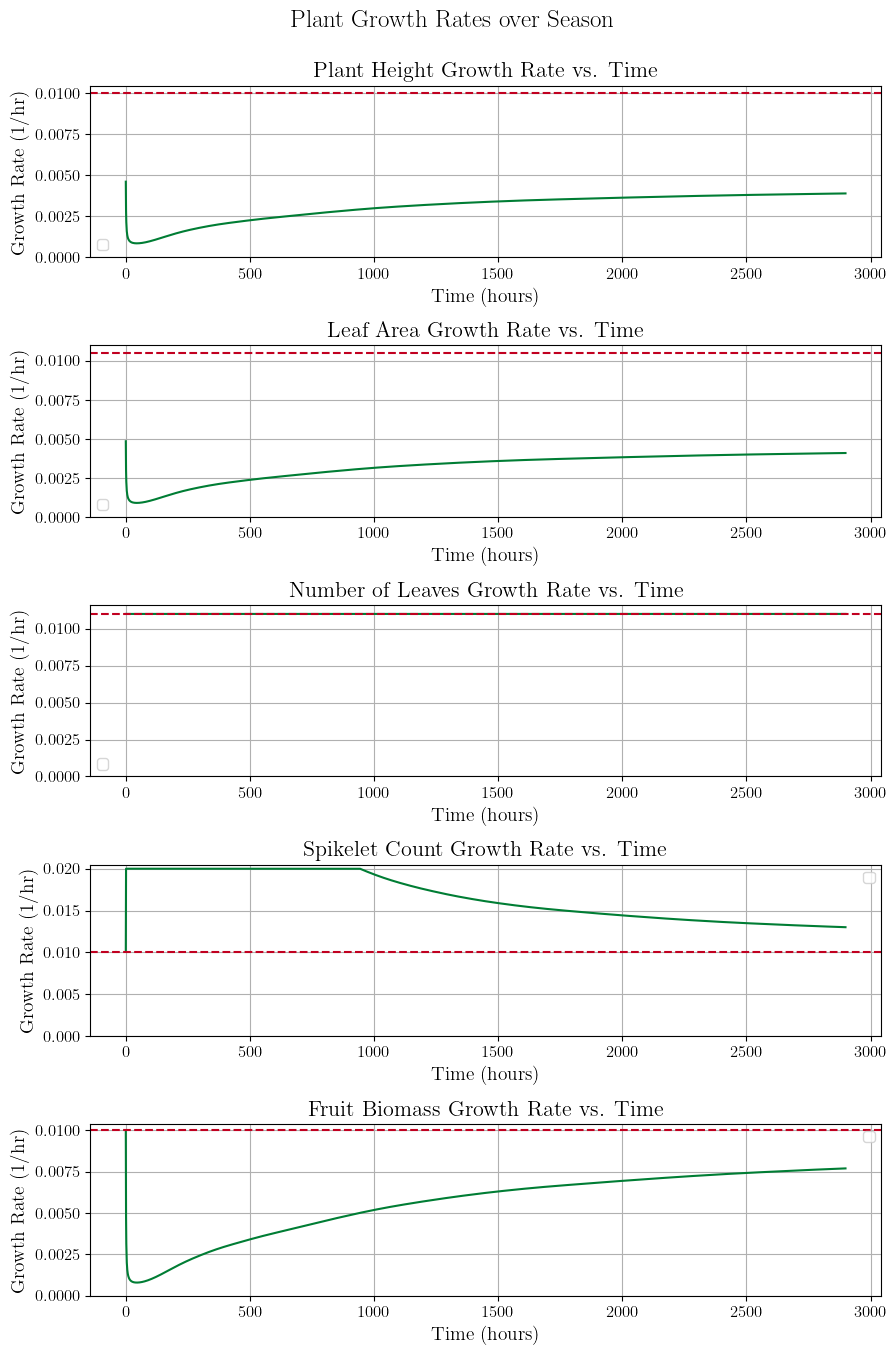

In [17]:
plot_growth_rate_evolution(
        growth_rates,
        [ah_hat],
        [aA_hat],
        [aN_hat],
        [ac_hat],
        [aP_hat],
)

## Plot carrying capacities over time

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:773: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:783: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/plotting/plotting.py:793: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ign

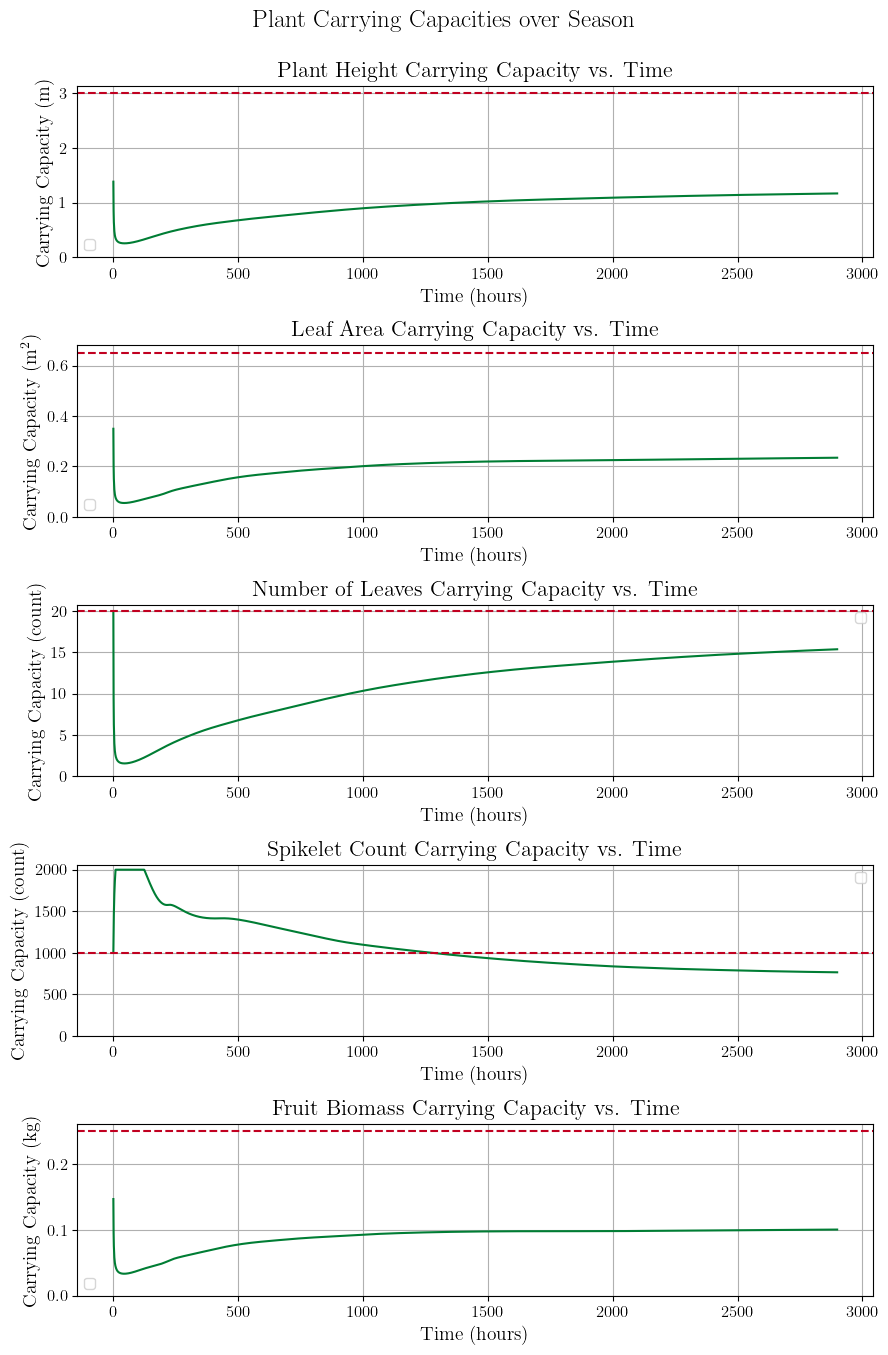

In [18]:
plot_carrying_capacity_evolution(
        carrying_capacities,
        [kh_hat],
        [kA_hat],
        [kN_hat],
        [kc_hat],
        [kP_hat]
)